## Comparison between xmask and pymask machines

### Imports modules

In [17]:
import numpy as np
import xtrack as xt
import xpart as xp
import pandas as pd
import json
import matplotlib.pyplot as plt

# Plotting function
from plotting_functions import plot_all

# Plotly renderer
import plotly.io as pio

# ! Renderer should be set to 'notebook' or 'vscode' (depending on the IDE used) for interactive plots
pio.renderers.default = "browser"

### Build pymask line

In [2]:
path = "pymask/xsuite_lines/line_bb_for_tracking.json"
with open(path) as fid:
    dd = json.load(fid)
p_co = xp.Particles.from_dict(dd["particle_on_tracker_co"])
pm_line = xt.Line.from_dict(dd)
pm_line.particle_ref = xp.Particles.from_dict(dd["particle_on_tracker_co"])
pm_line.build_tracker()

Done loading line from dict.           
Compiling ContextCpu kernels...


d99319d21f7945de895f761e7fc1c68a.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from d99319d21f7945de895f761e7fc1c68a.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.


### Build xmask line

In [3]:
collider = xt.Multiline.from_json("xmask/xsuite_lines/collider_03_tuned_bb_on.json")
collider.build_trackers()

b1 = True
if b1:
    xm_line = collider["lhcb1"]
else:
    xm_line = collider["lhcb2"]

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


33d5b1fab995439a9dbe76bc6fe2c49f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 33d5b1fab995439a9dbe76bc6fe2c49f.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


2592bd2fec9e4f0dacaa114054e36b2a.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 2592bd2fec9e4f0dacaa114054e36b2a.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Compare elements in both lines

#### Check element names which differ


In [4]:
# Get element names in pymask and xmask
set_pm = set(pm_line.element_names)
set_xm = set(xm_line.element_names)

# Get elements in pymask but not in xmask
set_pm_not_xm = set_pm - set_xm
print("Elements in pymask but not in xmask", set_pm_not_xm)
print(
    "Elements in xmask but not in pymask that are not drifts",
    [x for x in set_pm_not_xm if "drift" not in x],
)

# Get elements in xmask but not in pymask
set_xm_not_pm = set_xm - set_pm
print("Elements in pymask but not in xmask", set_xm_not_pm)
print("Elements in pymask but not in xmask", [x for x in set_xm_not_pm if "drift" not in x])

Elements in pymask but not in xmask {'drift_11945', 'drift_8674', 'drift_10233', 'drift_11967', 'drift_10321', 'drift_11832', 'drift_11842', 'drift_11873', 'drift_11972', 'drift_2919', 'drift_11867', 'drift_11977', 'drift_11831', 'drift_10285', 'drift_8619', 'drift_11982', 'drift_11828', 'drift_8588', 'drift_11782', 'drift_7184', 'drift_11827', 'drift_11814', 'drift_11979', 'drift_11952', 'drift_10222', 'drift_11907', 'drift_11801', 'drift_11896', 'drift_11770', 'drift_11788', 'drift_11894', 'drift_8584', 'drift_8648', 'drift_10390', 'drift_11800', 'drift_11887', 'drift_11899', 'drift_2894', 'drift_11961', 'drift_2787', 'drift_11958', 'drift_11890', 'drift_7214', 'drift_11937', 'drift_11983', 'drift_11783', 'drift_11849', 'drift_11850', 'drift_11825', 'drift_7073', 'drift_11909', 'drift_8740', 'drift_11857', 'drift_2861', 'drift_7077', 'drift_10392', 'drift_11809', 'drift_11943', 'drift_11900', 'drift_3006', 'drift_2744', 'drift_7238', 'drift_11781', 'drift_10258', 'drift_11778', 'drif

#### Check if some dipoles differ


In [5]:
dipole_names = [x for x in pm_line.element_names if "mb" in x]
for i, dipole in enumerate(dipole_names):
    class_element = pm_line[dipole].to_dict()["__class__"]
    if class_element != "Marker" and class_element != "Drift":
        try:
            if class_element == "SRotation":
                assert pm_line[dipole].cos_z == xm_line[dipole].cos_z
                assert pm_line[dipole].sin_z == xm_line[dipole].sin_z
                assert pm_line[dipole].angle == xm_line[dipole].angle
            else:
                assert pm_line[dipole].length == xm_line[dipole].length
                assert pm_line[dipole].hxl == xm_line[dipole].hxl
                assert pm_line[dipole].hyl == xm_line[dipole].hyl
                assert pm_line[dipole].knl[0] == xm_line[dipole].knl[0]
                assert pm_line[dipole].ksl[0] == xm_line[dipole].ksl[0]
        except:
            try:
                print("PM", dipole, pm_line[dipole].to_dict())
            except Exception as e:
                print(e)
            try:
                print("XM", dipole, xm_line[dipole].to_dict())
            except Exception as e:
                print(e)

#### Check if some multipoles differ 

In [6]:
def check_difference_multipoles(multipole_names, index_strength):
    for i, multipole in enumerate(multipole_names):
        class_element = pm_line[multipole].to_dict()["__class__"]
        if class_element != "Marker" and class_element != "Drift":
            try:
                assert pm_line[multipole].length == xm_line[multipole].length
                assert pm_line[multipole].hxl == xm_line[multipole].hxl
                assert pm_line[multipole].hyl == xm_line[multipole].hyl
                assert np.allclose(
                    pm_line[multipole].knl[index_strength], xm_line[multipole].knl[index_strength]
                )
                assert np.allclose(
                    pm_line[multipole].ksl[index_strength], xm_line[multipole].ksl[index_strength]
                )
            except:
                try:
                    print("PM", multipole, pm_line[multipole].to_dict())
                except Exception as e:
                    print(e)
                try:
                    print("XM", multipole, xm_line[multipole].to_dict())
                except Exception as e:
                    print(e)

In [7]:
# Quadrupoles
quadrupole_names = [x for x in pm_line.element_names if "mq" in x]
check_difference_multipoles(quadrupole_names, 1)

PM mqt.14r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.34465922e-05]), 'ksl': array([0., 0.])}
XM mqt.14r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.33676659e-05]), 'ksl': array([0., 0.])}
PM mqt.14r3.b1..2 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.34465922e-05]), 'ksl': array([0., 0.])}
XM mqt.14r3.b1..2 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.33676659e-05]), 'ksl': array([0., 0.])}
PM mqt.15r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 

In [8]:
# Sextupoles
sextupole_names = [x for x in pm_line.element_names if "ms" in x]
check_difference_multipoles(sextupole_names, 2)

PM ms.11r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02854975]), 'ksl': array([0., 0., 0.])}
XM ms.11r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02854927]), 'ksl': array([0., 0., 0.])}
PM ms.13r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02854975]), 'ksl': array([0., 0., 0.])}
XM ms.13r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02854927]), 'ksl': array([0., 0., 0.])}
PM ms.15r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0

In [9]:
# Octupoles
octupole_names = [x for x in pm_line.element_names if "mo" in x]
check_difference_multipoles(octupole_names, 3)

### Check that main observables are the same

In [10]:
tw_xm_1 = collider["lhcb1"].twiss()
tw_xm_2 = collider["lhcb2"].twiss().reverse()
tw_pm_1 = pm_line.twiss()

In [11]:
print("Tune pymask x:", tw_pm_1.qx)
print("Tune xmask x:", tw_xm_1.qx)
print()
print("Tune pymask y:", tw_pm_1.qy)
print("Tune xmask y:", tw_xm_1.qy)
print()
print("Chromaticity pymask x:", tw_pm_1.dqx)
print("Chromaticity xmask x:", tw_xm_1.dqx)
print()
print("Chromaticity pymask y:", tw_pm_1.dqy)
print("Chromaticity xmask y:", tw_xm_1.dqy)
print()
print("Linear coupling pymask:", tw_pm_1.c_minus)
print("Linear coupling xmask:", tw_xm_1.c_minus)


Tune pymask x: 62.29303089592539
Tune xmask x: 62.292995980979406

Tune pymask y: 60.29949403459247
Tune xmask y: 60.29946119609988

Chromaticity pymask x: 13.58877430064853
Chromaticity xmask x: 14.26997459919671

Chromaticity pymask y: 12.17766786340918
Chromaticity xmask y: 12.431281433196439

Linear coupling pymask: 0.0020127589953318455
Linear coupling xmask: 0.002020131593531488


In [12]:
for ip in [1,2,5,8]:
    print("Pymask", tw_pm_1.rows[f'ip{ip}'].cols['s', 'x', 'px', 'y', 'py'].to_pandas())
    print("Xmask", tw_xm_1.rows[f'ip{ip}'].cols['s', 'x', 'px', 'y', 'py'].to_pandas())
    print()

Pymask   name           s             x       px             y            py
0  ip1  19994.1624 -9.045491e-08  0.00025 -1.112831e-08  2.722492e-07
Xmask   name           s             x       px             y            py
0  ip1  19994.1624 -9.062047e-08  0.00025 -1.164190e-08  2.686874e-07

Pymask   name             s         x            px             y      py
0  ip2  23326.598984 -0.000138  2.225068e-07 -9.050333e-08 -0.0001
Xmask   name             s         x            px             y      py
0  ip2  23326.598984 -0.000138  2.239191e-07 -8.557021e-08 -0.0001

Pymask   name            s             x            px             y       py
0  ip5  6664.568433  7.121515e-08  1.364078e-07 -2.407125e-08  0.00025
Xmask   name            s             x            px             y       py
0  ip5  6664.568433  6.977318e-08  1.334221e-07 -2.481512e-08  0.00025

Pymask   name             s             x        px             y        py
0  ip8  16650.658184 -3.109880e-07  0.000135 -3.22

### Replace the pymaks bb values with the xmask ones

In [13]:
for x in collider.lhcb1.element_dict:#collider.lhcb1.element_dict:
    dic_el = collider.lhcb1.element_dict[x].to_dict()
    if "bb" in x and dic_el['__class__']!='Drift':
        for key in dic_el:
            if key!='__class__':
                setattr(pm_line.element_refs[x], key, dic_el[key])

tw_pm_1 = pm_line.twiss()


In [14]:
print("Tune pymask x:", tw_pm_1.qx)
print("Tune xmask x:", tw_xm_1.qx)
print()
print("Tune pymask y:", tw_pm_1.qy)
print("Tune xmask y:", tw_xm_1.qy)
print()
print("Chromaticity pymask x:", tw_pm_1.dqx)
print("Chromaticity xmask x:", tw_xm_1.dqx)
print()
print("Chromaticity pymask y:", tw_pm_1.dqy)
print("Chromaticity xmask y:", tw_xm_1.dqy)
print()
print("Linear coupling pymask:", tw_pm_1.c_minus)
print("Linear coupling xmask:", tw_xm_1.c_minus)

Tune pymask x: 62.29305887764695
Tune xmask x: 62.292995980979406

Tune pymask y: 60.29951833387453
Tune xmask y: 60.29946119609988

Chromaticity pymask x: 14.278474090709814
Chromaticity xmask x: 14.26997459919671

Chromaticity pymask y: 12.437746573356334
Chromaticity xmask y: 12.431281433196439

Linear coupling pymask: 0.0020232613058173954
Linear coupling xmask: 0.002020131593531488


### Plot everything in an interactive widget

In [15]:
fig = plot_all(tw_pm_1, tw_xm_1, tw_xm_2)

fig.write_html("widgets/widget.html", config = {'displayModeBar': False})
fig.show(config = {'displayModeBar': False})

### Plot footprint again

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


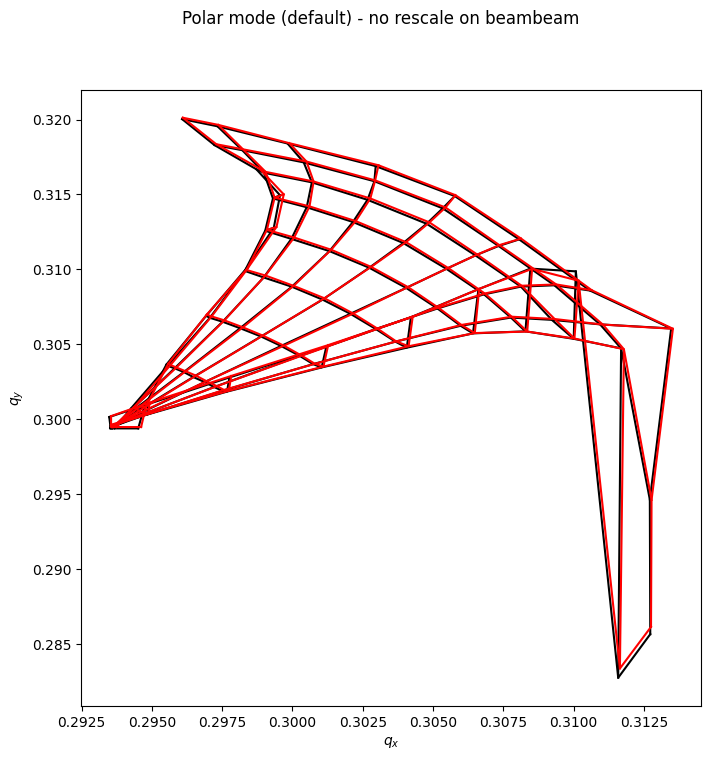

In [22]:
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1)],
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar_xm.plot(ax=ax, label="no rescale bb")
#plt.suptitle("Polar mode (default) - no rescale on beambeam. Xmask.")
#plt.show()

# Set knob for 'on_bb_charge' for pymask
for i, x in enumerate(tw_pm_1.to_pandas().name):
    if "bb_lr" in x or "bb_ho" in x:
        pm_line.element_refs[x].scale_strength = pm_line.vars["on_bb_charge"]

fp_polar = pm_line.get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="on_bb_charge", v0=0.0, dv=0.1)],
)

#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar.plot(ax=ax, label="no rescale bb", color = 'red')
plt.suptitle("Polar mode (default) - no rescale on beambeam")
plt.show()
